#Bank Churn Prediction -- Neural Network


###Data Dictionary



1. CustomerId: Unique ID which is assigned to each customer

2. Surname: Last name of the customer

3. CreditScore: It defines the credit history of the customer.

4. Geography: A customer’s location

5. Gender: It defines the Gender of the customer

6. Age: Age of the customer

7. Tenure: Number of years for which the customer has been with the bank

8. NumOfProducts: refers to the number of products that a customer has purchased through the bank.

9. Balance: Account balance

10. HasCrCard: It is a categorical variable which decides whether the customer has credit card or not.

11. EstimatedSalary: Estimated salary

12. isActiveMember: Is is a categorical variable which decides whether the customer is active member of the bank or not ( Active member in the sense, using bank products regularly, making transactions etc )

13. Exited : whether or not the customer left the bank within six month. It can take two values

  *0=No ( Customer did not leave the bank )
  *1=Yes ( Customer left the bank )



##Importing necessary libraries

In [ ]:
# Libraries to help with reading and manipulating data
import numpy as np
import pandas as pd
# libaries to help with data visualization
import matplotlib.pyplot as pyplot
import matplotlib.pyplot as plt
import seaborn as sns
# Library to split data
from sklearn.model_selection import train_test_split
# library to import to standardize the data
from sklearn.preprocessing import StandardScaler
#To import different metrics
from sklearn.metrics import explained_variance_score, mean_squared_error, r2_score, mean_absolute_error
#Importing classback API
from keras import callbacks
# Importing tensorflow library
import tensorflow as tf
# importing different functions to build models
from tensorflow.keras.layers import Dense, Dropout,InputLayer
from tensorflow.keras.models import Sequential
# Importing Batch Normalization
from keras.layers import BatchNormalization
# Importing backend
from tensorflow.keras import backend
# Importing shffule
from random import shuffle
from keras.callbacks import ModelCheckpoint
# Importing optimizers
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.optimizers import RMSprop
# Library to avoid the warnings
import warnings
warnings.filterwarnings("ignore")

##Reading the Dataset

In [ ]:
data = pd.read_csv("Churn.csv")

In [ ]:
#data preview
data.head()

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0


In [ ]:
#Information on the data
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   RowNumber        10000 non-null  int64  
 1   CustomerId       10000 non-null  int64  
 2   Surname          10000 non-null  object 
 3   CreditScore      10000 non-null  int64  
 4   Geography        10000 non-null  object 
 5   Gender           10000 non-null  object 
 6   Age              10000 non-null  int64  
 7   Tenure           10000 non-null  int64  
 8   Balance          10000 non-null  float64
 9   NumOfProducts    10000 non-null  int64  
 10  HasCrCard        10000 non-null  int64  
 11  IsActiveMember   10000 non-null  int64  
 12  EstimatedSalary  10000 non-null  float64
 13  Exited           10000 non-null  int64  
dtypes: float64(2), int64(9), object(3)
memory usage: 1.1+ MB


In [ ]:
#Check the shape of the data
print(f'There is {data.shape[0]} rows in this data measured across {data.shape[1]} features')

There is 10000 rows in this data measured across 14 features


###How many missing values are in the data

In [ ]:
print(f'There are {data.isna().sum().sum()} missing values in the data')

There are 0 missing values in the data


###Value duplications?

In [ ]:
# Let's check for duplicate values in the data
data.duplicated().sum()

0

#Exploratory Data Analysis

In [ ]:
#User defined function for batch univariate data analysis of quantitative features in a dataset
def univariate_analysis(data, feature, include_def = False):
  """
  This function computes major and minor outliers
  as defined in 'Introduction to Contemporary Statistical Methods --  second edition' by Dr. Lambert H. Koopmans (pg. 53).
  Minor outliers are defined by those values which are beyond Q3/Q1 +/- 1.5*IQR but less than Q3/Q1 +/- 3*IQR
  Major/Extreme outliers are defined by those values which are beyond Q3/Q1 +/- 3*IQR
  Also, this function computes other relevant statistics and plots germane to a univariate analysis of a random variable.

  Please note the following definitions/descriptions of skewness and kurtosis from the Engineering Statistics Handbook (https://www.itl.nist.gov/div898/handbook/eda/section3/eda35b.htm):
  *Skewness is a measure of symmetry, or more precisely, the lack of symmetry. A distribution, or data set, is symmetric if it looks the same to the left and right of the center point.
  **Kurtosis is a measure of whether the data are heavy-tailed or light-tailed relative to a normal distribution. That is, data sets with high kurtosis tend to have heavy tails, or outliers.
  **Data sets with low kurtosis tend to have light tails, or lack of outliers. A uniform distribution would be the extreme case.
  """

  ##Display Plots
  fig, axes = plt.subplots(ncols = 3, figsize = (15,5))
  sns.boxplot(data = data, x = feature, ax = axes[0]).set(title = f'Boxplot of {feature}')
  sns.histplot(data = data, x = feature, ax = axes[1]).set(title = f'Histogram plot of {feature}')
  sns.kdeplot(data = data, x = feature, ax = axes[2]).set(title = f'Density plot of {feature}')
  plt.show()

  Q1 = data[feature].quantile(.25) ; Q3 = data[feature].quantile(.75) ; Q2 = data[feature].quantile(.5) ; Mean = data[feature].mean()
  STD = np.std(data[feature]); SNR = Mean/STD ; CV = STD/Mean ; Skew = skew(data[feature], nan_policy = 'omit') ; Kurtosis = kurtosis(data[feature], nan_policy = 'omit')
  IQR = Q3 - Q1
  upper_fence = Q3 + 1.5*IQR ; lower_fence = Q1 - 1.5*IQR
  outer_upper_fence = Q3 + 3*IQR ; outer_lower_fence = Q1 - 3*IQR
  minor_outliers_Q3 = []
  major_outliers_Q3 = []
  minor_outliers_Q1 = []
  major_outliers_Q1 = []
  for i in range(data[(data[feature]>upper_fence) & (data[feature]<=outer_upper_fence)].shape[0]):
    minor_outliers_Q3.append(data[(data[feature]>upper_fence) & (data[feature]<=outer_upper_fence)].loc[:,feature].values[i])
  if len(minor_outliers_Q3) == 0:
    print('*There are no minor outliers beyond Quartile-3 + 1.5*IQR!')
  else:
    print('*The number of minor outliers beyond Quartile-3 + 1.5*IQR are:', len(minor_outliers_Q3), 'and the average of these outliers are:', round(pd.Series(minor_outliers_Q3).mean(), ndigits=2))
  for i in range(data[data[feature]> outer_upper_fence].shape[0]):
    major_outliers_Q3.append(data[data[feature]> outer_upper_fence].loc[:,feature].values[i])
  if len(major_outliers_Q3) == 0:
    print('*There are no major outliers beyond Quartile-3 + 3*IQR!')
  else:
    print('*The number major outliers beyond Quartile-3 + 3*IQR are:', len(major_outliers_Q3), 'and the average of these outliers are:', round(pd.Series(major_outliers_Q3).mean(), ndigits=2))
  for i in range(data[(data[feature]>= outer_lower_fence) & (data[feature]<lower_fence)].shape[0]):
    minor_outliers_Q1.append(data[(data[feature]>= outer_lower_fence) & (data[feature]<lower_fence)].loc[:,feature].values[i])
  if len(minor_outliers_Q1) == 0:
    print('*There are no minor outliers below Quartile-1 - 1.5*IQR!')
  else:
    print('*The number of minor outliers below Quartile-1 - 1.5*IQR are:', len(minor_outliers_Q1), 'and the average of these outliers are:', round(pd.Series(minor_outliers_Q1).mean(), ndigits=2))
  for i in range(data[(data[feature]<outer_lower_fence)].shape[0]):
    major_outliers_Q1.append(data[(data[feature]<outer_lower_fence)].loc[:,feature].values[i])
  if len(major_outliers_Q1) == 0:
    print('*There are no major outliers below Quartile-1 - 3*IQR!')
  else:
    print('*The number major outliers below Quartile-1 - 3*IQR are:', len(major_outliers_Q1), 'and the average of these outliers are:', round(pd.Series(major_outliers_Q1).mean(), ndigits=2))
  print('-'*50)
  print('-'*50)
  print('*Quartile-1 is:', round(Q1, ndigits=2))
  print('*Quartile-2 (median) is:', round(Q2, ndigits = 2))
  print('*Quartile-3 is:', round(Q3, ndigits = 2))
  print('*Quartile-1 - 1.5*IQR = ', round(lower_fence, ndigits = 2))
  print('*Quartile-1 - 3*IQR = ', round(outer_lower_fence, ndigits=2))
  print('*Quartile-3 + 1.5*IQR = ', round(upper_fence, ndigits=2))
  print('*Quartile-3 + 3*IQR = ', round(outer_upper_fence, ndigits=2))
  print('-'*50)
  print('-'*50)
  print(f'*Average of {feature} is:', round(Mean, ndigits=2))
  print(f'*Standard deviation of {feature} is:', round(STD, ndigits=2))
  print(f'*Skewness of {feature} is:', round(Skew, ndigits=2))
  print(f'*Kurtosis of {feature} is:', round(Kurtosis, ndigits = 2))
  print(f'*Coefficient of variation of {feature} is:', round(CV, ndigits = 2))
  if data[feature].min()>=0:
    print(f'*Signal to Noise Ratio of {feature} is:', round(SNR, ndigits=2))
    print('**Note: Signal to Noise Ratio statistic is only applicable to variables which are always non-negative**')
  else:
    print('*Signal to Noise Ratio DOES NOT EXIST')
  print('-'*50)
  print('-'*50)

  if include_def == True:
    print('**Definitions:')
    print(f'*Skewness is a measure of symmetry, or more precisely, the lack of symmetry. \n A distribution, or data set, is symmetric if it looks the same to the left and right of the center point.')

    print(f'*Kurtosis is a measure of whether the data are heavy-tailed or light-tailed relative to a normal distribution. \n That is, data sets with high kurtosis tend to have heavy tails, or outliers. \n Data sets with low kurtosis tend to have light tails, or lack of outliers. A uniform distribution would be the extreme case.')







In [ ]:
# function to create labeled barplots


def labeled_barplot(data, feature, perc=False, n=None):
    """
    Barplot with percentage at the top

    data: dataframe
    feature: dataframe column
    perc: whether to display percentages instead of count (default is False)
    n: displays the top n category levels (default is None, i.e., display all levels)
    """

    total = len(data[feature])  # length of the column
    count = data[feature].nunique()
    if n is None:
        plt.figure(figsize=(count + 1, 5))
    else:
        plt.figure(figsize=(n + 1, 5))

    plt.xticks(rotation=90, fontsize=15)
    ax = sns.countplot(
        data=data,
        x=feature,
        palette="Paired",
        order=data[feature].value_counts().index[:n].sort_values(),
    )

    for p in ax.patches:
        if perc == True:
            label = "{:.1f}%".format(
                100 * p.get_height() / total
            )  # percentage of each class of the category
        else:
            label = p.get_height()  # count of each level of the category

        x = p.get_x() + p.get_width() / 2  # width of the plot
        y = p.get_height()  # height of the plot

        ax.annotate(
            label,
            (x, y),
            ha="center",
            va="center",
            size=12,
            xytext=(0, 5),
            textcoords="offset points",
        )  # annotate the percentage

    plt.show()  # show the plot

In [ ]:
numeric_col = []
for i in range(data.shape[1]):
    if data.dtypes[i] == 'int64' or data.dtypes[i] == 'float64':
        numeric_col.append(data.dtypes.index[i])
print(f'The numeric features of the data are: {numeric_col}')


The numeric features of the data are: ['RowNumber', 'CustomerId', 'CreditScore', 'Age', 'Tenure', 'Balance', 'NumOfProducts', 'HasCrCard', 'IsActiveMember', 'EstimatedSalary', 'Exited']


In [ ]:
#Remove rownumber, customerID, HasCrCard and Exited
numeric_col.remove('RowNumber')
numeric_col.remove('CustomerId')
numeric_col.remove('Exited')
numeric_col.remove('HasCrCard')

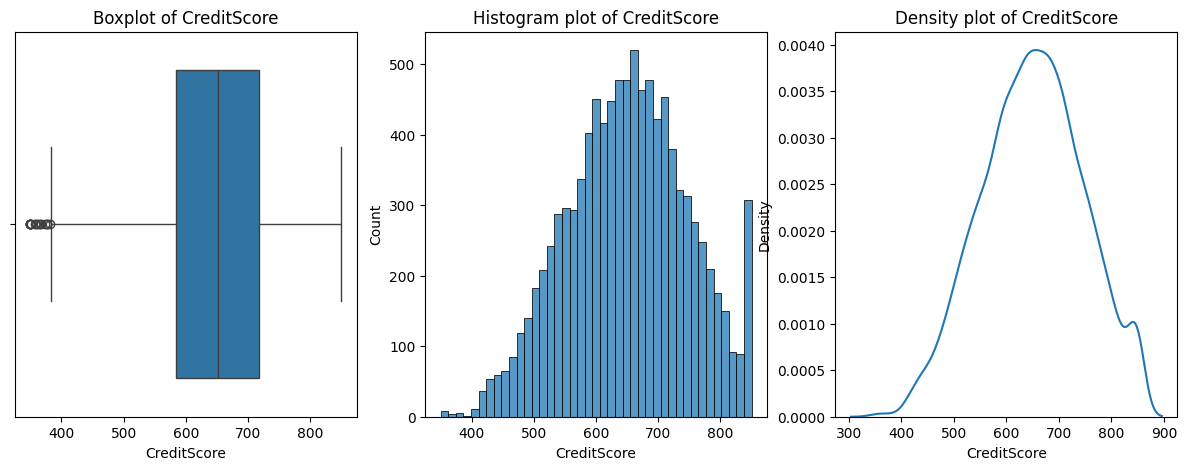

*There are no minor outliers beyond Quartile-3 + 1.5*IQR!
*There are no major outliers beyond Quartile-3 + 3*IQR!
*The number of minor outliers below Quartile-1 - 1.5*IQR are: 15 and the average of these outliers are: 361.33
*There are no major outliers below Quartile-1 - 3*IQR!
--------------------------------------------------
--------------------------------------------------
*Quartile-1 is: 584.0
*Quartile-2 (median) is: 652.0
*Quartile-3 is: 718.0
*Quartile-1 - 1.5*IQR =  383.0
*Quartile-1 - 3*IQR =  182.0
*Quartile-3 + 1.5*IQR =  919.0
*Quartile-3 + 3*IQR =  1120.0
--------------------------------------------------
--------------------------------------------------
*Average of CreditScore is: 650.53
*Standard deviation of CreditScore is: 96.65
*Skewness of CreditScore is: -0.07
*Kurtosis of CreditScore is: -0.43
*Coefficient of variation of CreditScore is: 0.15
*Signal to Noise Ratio of CreditScore is: 6.73
**Note: Signal to Noise Ratio statistic is only applicable to variables w

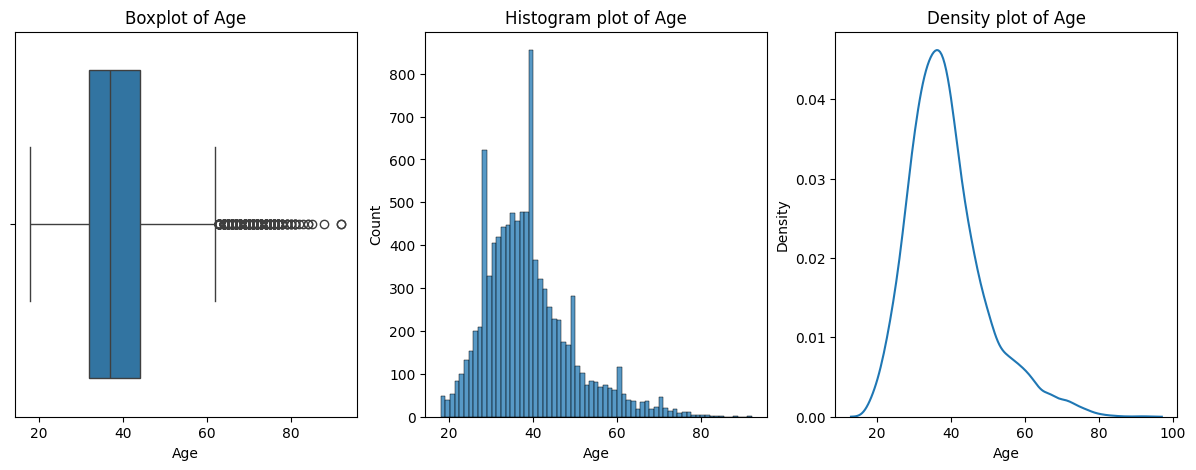

*The number of minor outliers beyond Quartile-3 + 1.5*IQR are: 347 and the average of these outliers are: 68.74
*The number major outliers beyond Quartile-3 + 3*IQR are: 12 and the average of these outliers are: 84.5
*There are no minor outliers below Quartile-1 - 1.5*IQR!
*There are no major outliers below Quartile-1 - 3*IQR!
--------------------------------------------------
--------------------------------------------------
*Quartile-1 is: 32.0
*Quartile-2 (median) is: 37.0
*Quartile-3 is: 44.0
*Quartile-1 - 1.5*IQR =  14.0
*Quartile-1 - 3*IQR =  -4.0
*Quartile-3 + 1.5*IQR =  62.0
*Quartile-3 + 3*IQR =  80.0
--------------------------------------------------
--------------------------------------------------
*Average of Age is: 38.92
*Standard deviation of Age is: 10.49
*Skewness of Age is: 1.01
*Kurtosis of Age is: 1.39
*Coefficient of variation of Age is: 0.27
*Signal to Noise Ratio of Age is: 3.71
**Note: Signal to Noise Ratio statistic is only applicable to variables which are a

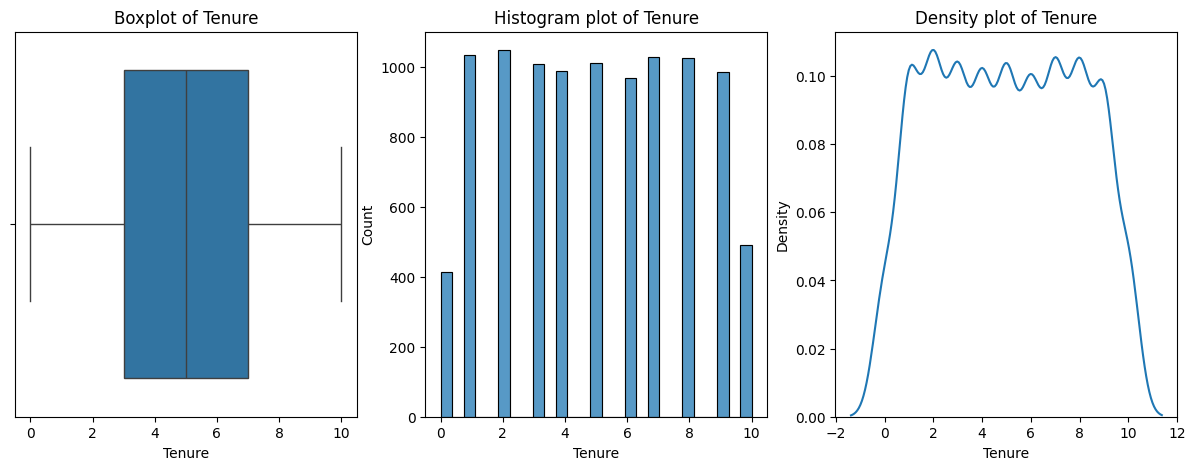

*There are no minor outliers beyond Quartile-3 + 1.5*IQR!
*There are no major outliers beyond Quartile-3 + 3*IQR!
*There are no minor outliers below Quartile-1 - 1.5*IQR!
*There are no major outliers below Quartile-1 - 3*IQR!
--------------------------------------------------
--------------------------------------------------
*Quartile-1 is: 3.0
*Quartile-2 (median) is: 5.0
*Quartile-3 is: 7.0
*Quartile-1 - 1.5*IQR =  -3.0
*Quartile-1 - 3*IQR =  -9.0
*Quartile-3 + 1.5*IQR =  13.0
*Quartile-3 + 3*IQR =  19.0
--------------------------------------------------
--------------------------------------------------
*Average of Tenure is: 5.01
*Standard deviation of Tenure is: 2.89
*Skewness of Tenure is: 0.01
*Kurtosis of Tenure is: -1.17
*Coefficient of variation of Tenure is: 0.58
*Signal to Noise Ratio of Tenure is: 1.73
**Note: Signal to Noise Ratio statistic is only applicable to variables which are always non-negative**
--------------------------------------------------
-----------------

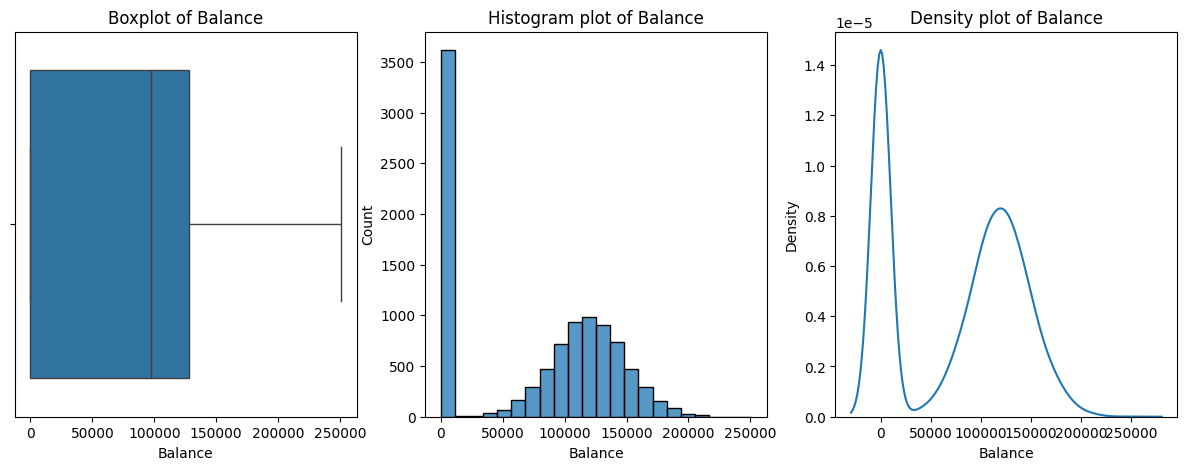

*There are no minor outliers beyond Quartile-3 + 1.5*IQR!
*There are no major outliers beyond Quartile-3 + 3*IQR!
*There are no minor outliers below Quartile-1 - 1.5*IQR!
*There are no major outliers below Quartile-1 - 3*IQR!
--------------------------------------------------
--------------------------------------------------
*Quartile-1 is: 0.0
*Quartile-2 (median) is: 97198.54
*Quartile-3 is: 127644.24
*Quartile-1 - 1.5*IQR =  -191466.36
*Quartile-1 - 3*IQR =  -382932.72
*Quartile-3 + 1.5*IQR =  319110.6
*Quartile-3 + 3*IQR =  510576.96
--------------------------------------------------
--------------------------------------------------
*Average of Balance is: 76485.89
*Standard deviation of Balance is: 62394.29
*Skewness of Balance is: -0.14
*Kurtosis of Balance is: -1.49
*Coefficient of variation of Balance is: 0.82
*Signal to Noise Ratio of Balance is: 1.23
**Note: Signal to Noise Ratio statistic is only applicable to variables which are always non-negative**
---------------------

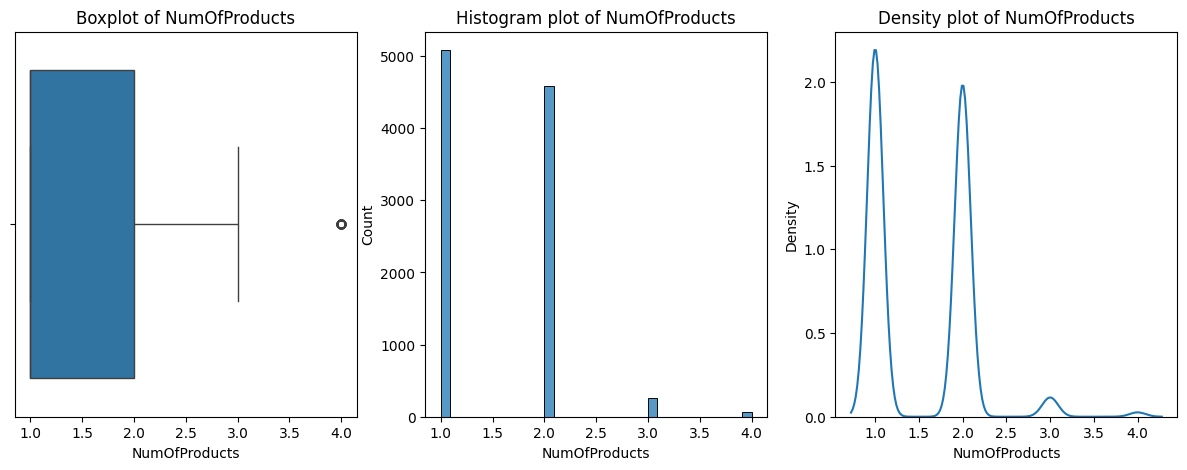

*The number of minor outliers beyond Quartile-3 + 1.5*IQR are: 60 and the average of these outliers are: 4.0
*There are no major outliers beyond Quartile-3 + 3*IQR!
*There are no minor outliers below Quartile-1 - 1.5*IQR!
*There are no major outliers below Quartile-1 - 3*IQR!
--------------------------------------------------
--------------------------------------------------
*Quartile-1 is: 1.0
*Quartile-2 (median) is: 1.0
*Quartile-3 is: 2.0
*Quartile-1 - 1.5*IQR =  -0.5
*Quartile-1 - 3*IQR =  -2.0
*Quartile-3 + 1.5*IQR =  3.5
*Quartile-3 + 3*IQR =  5.0
--------------------------------------------------
--------------------------------------------------
*Average of NumOfProducts is: 1.53
*Standard deviation of NumOfProducts is: 0.58
*Skewness of NumOfProducts is: 0.75
*Kurtosis of NumOfProducts is: 0.58
*Coefficient of variation of NumOfProducts is: 0.38
*Signal to Noise Ratio of NumOfProducts is: 2.63
**Note: Signal to Noise Ratio statistic is only applicable to variables which are 

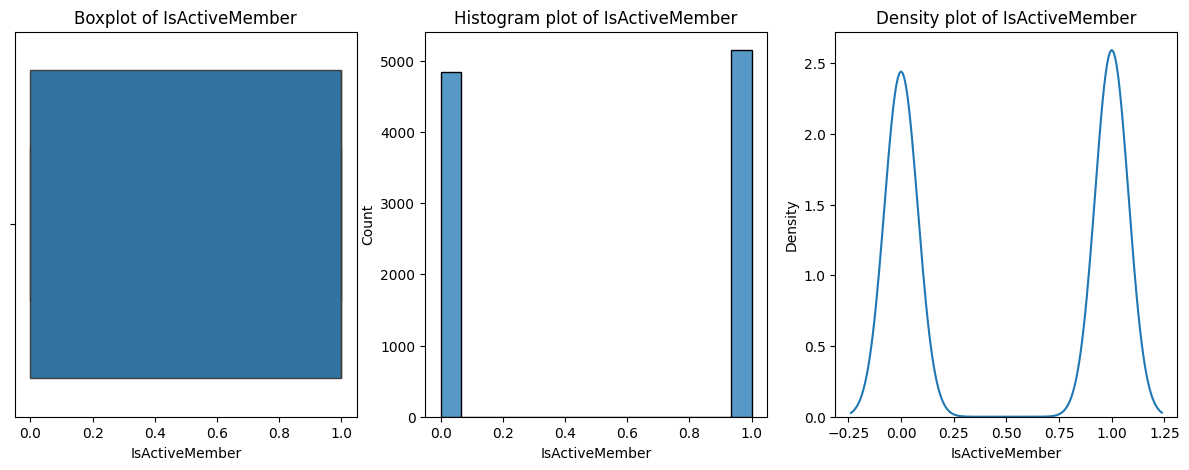

*There are no minor outliers beyond Quartile-3 + 1.5*IQR!
*There are no major outliers beyond Quartile-3 + 3*IQR!
*There are no minor outliers below Quartile-1 - 1.5*IQR!
*There are no major outliers below Quartile-1 - 3*IQR!
--------------------------------------------------
--------------------------------------------------
*Quartile-1 is: 0.0
*Quartile-2 (median) is: 1.0
*Quartile-3 is: 1.0
*Quartile-1 - 1.5*IQR =  -1.5
*Quartile-1 - 3*IQR =  -3.0
*Quartile-3 + 1.5*IQR =  2.5
*Quartile-3 + 3*IQR =  4.0
--------------------------------------------------
--------------------------------------------------
*Average of IsActiveMember is: 0.52
*Standard deviation of IsActiveMember is: 0.5
*Skewness of IsActiveMember is: -0.06
*Kurtosis of IsActiveMember is: -2.0
*Coefficient of variation of IsActiveMember is: 0.97
*Signal to Noise Ratio of IsActiveMember is: 1.03
**Note: Signal to Noise Ratio statistic is only applicable to variables which are always non-negative**
-----------------------

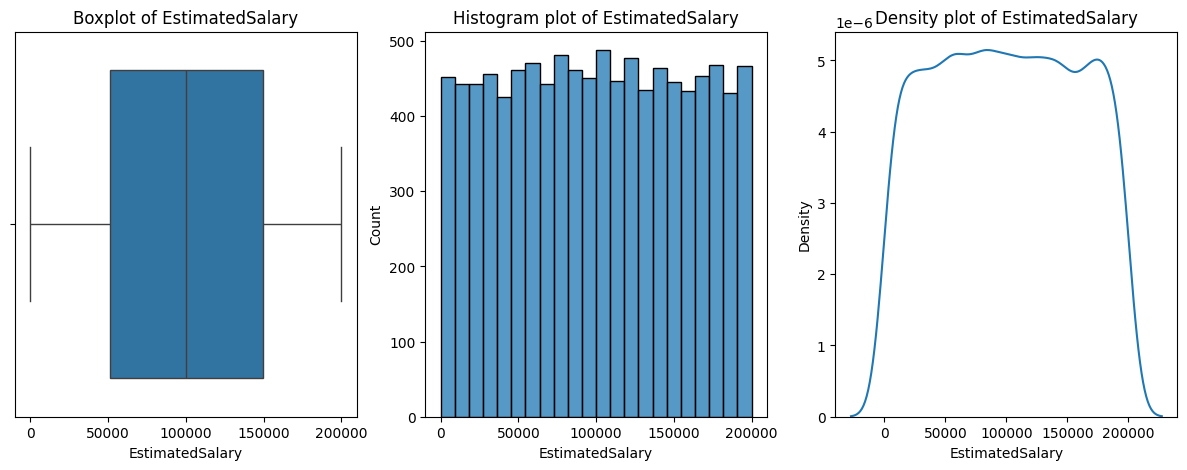

*There are no minor outliers beyond Quartile-3 + 1.5*IQR!
*There are no major outliers beyond Quartile-3 + 3*IQR!
*There are no minor outliers below Quartile-1 - 1.5*IQR!
*There are no major outliers below Quartile-1 - 3*IQR!
--------------------------------------------------
--------------------------------------------------
*Quartile-1 is: 51002.11
*Quartile-2 (median) is: 100193.92
*Quartile-3 is: 149388.25
*Quartile-1 - 1.5*IQR =  -96577.1
*Quartile-1 - 3*IQR =  -244156.3
*Quartile-3 + 1.5*IQR =  296967.45
*Quartile-3 + 3*IQR =  444546.66
--------------------------------------------------
--------------------------------------------------
*Average of EstimatedSalary is: 100090.24
*Standard deviation of EstimatedSalary is: 57507.62
*Skewness of EstimatedSalary is: 0.0
*Kurtosis of EstimatedSalary is: -1.18
*Coefficient of variation of EstimatedSalary is: 0.57
*Signal to Noise Ratio of EstimatedSalary is: 1.74
**Note: Signal to Noise Ratio statistic is only applicable to variables wh

In [ ]:
#Batch Univariate Analysis
for i in numeric_col:
  univariate_analysis(data, i, include_def = True)

In [ ]:
#Statistical summary of numeric variables
data[numeric_col].describe().T

,count,mean,std,min,25%,50%,75%,max
CreditScore,10000.0,650.528800,96.653299,350.00,584.00,652.000,718.0000,850.00
Age,10000.0,38.921800,10.487806,18.00,32.00,37.000,44.0000,92.00
Tenure,10000.0,5.012800,2.892174,0.00,3.00,5.000,7.0000,10.00
Balance,10000.0,76485.889288,62397.405202,0.00,0.00,97198.540,127644.2400,250898.09
NumOfProducts,10000.0,1.530200,0.581654,1.00,1.00,1.000,2.0000,4.00
IsActiveMember,10000.0,0.515100,0.499797,0.00,0.00,1.000,1.0000,1.00
EstimatedSalary,10000.0,100090.239881,57510.492818,11.58,51002.11,100193.915,149388.2475,199992.48


Of note, 25% of bank customers have a zero balance with the bank -- unclear at this stage the significance of this finding.

In [ ]:
# make HasCrCard a categorical variable
data['HasCrCard'] = data['HasCrCard'].astype('object')

In [ ]:
categorical_col = []
for i in range(data.shape[1]):
    if data.dtypes[i] == 'object':
        categorical_col.append(data.dtypes.index[i])
print(f'The categorical features of the data are: {categorical_col}')


The categorical features of the data are: ['Surname', 'Geography', 'Gender', 'HasCrCard']


In [ ]:
#Remove Surname from categorical_col
categorical_col.remove('Surname')

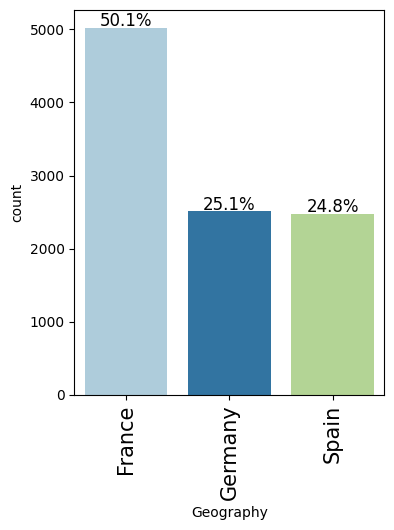

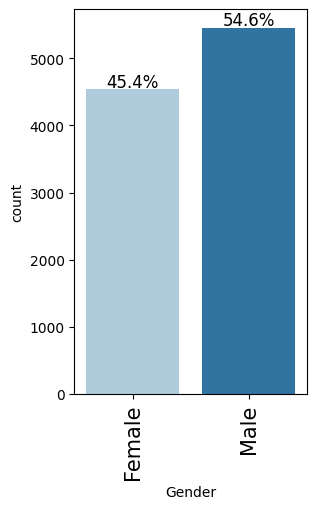

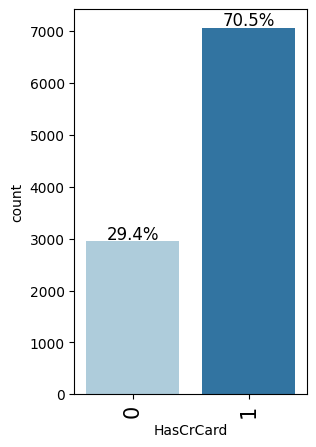

In [ ]:
#Batch categorical analysis
for i in categorical_col:
  labeled_barplot(data, i, perc=True)

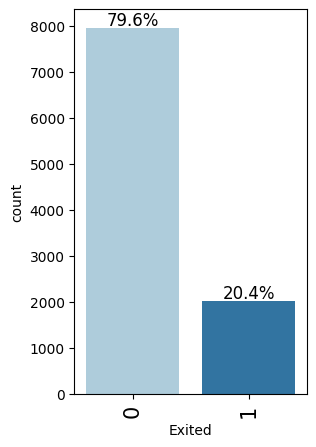

In [ ]:
#Exited variable distribution
labeled_barplot(data, 'Exited', perc=True)

As demonstrated, 20.4% of customers were classified as having left the bank -- this will be our target variable in terms of attempting to predict why customers did so.

##Bivariate Analysis

In [ ]:
# user defined function to plot stacked bar chart


def stacked_barplot(data, predictor, target):
    """
    Print the category counts and plot a stacked bar chart

    data: dataframe
    predictor: independent variable
    target: target variable
    """
    count = data[predictor].nunique()
    sorter = data[target].value_counts().index[-1]
    tab1 = pd.crosstab(data[predictor], data[target], margins=True).sort_values(
        by=sorter, ascending=False
    )
    print(tab1)
    print("-" * 120)
    tab = pd.crosstab(data[predictor], data[target], normalize="index").sort_values(
        by=sorter, ascending=False
    )
    tab.plot(kind="bar", stacked=True, figsize=(count + 1, 5))
    plt.legend(
        loc="lower left",
        frameon=False,
    )
    plt.legend(loc="upper left", bbox_to_anchor=(1, 1))
    plt.show()

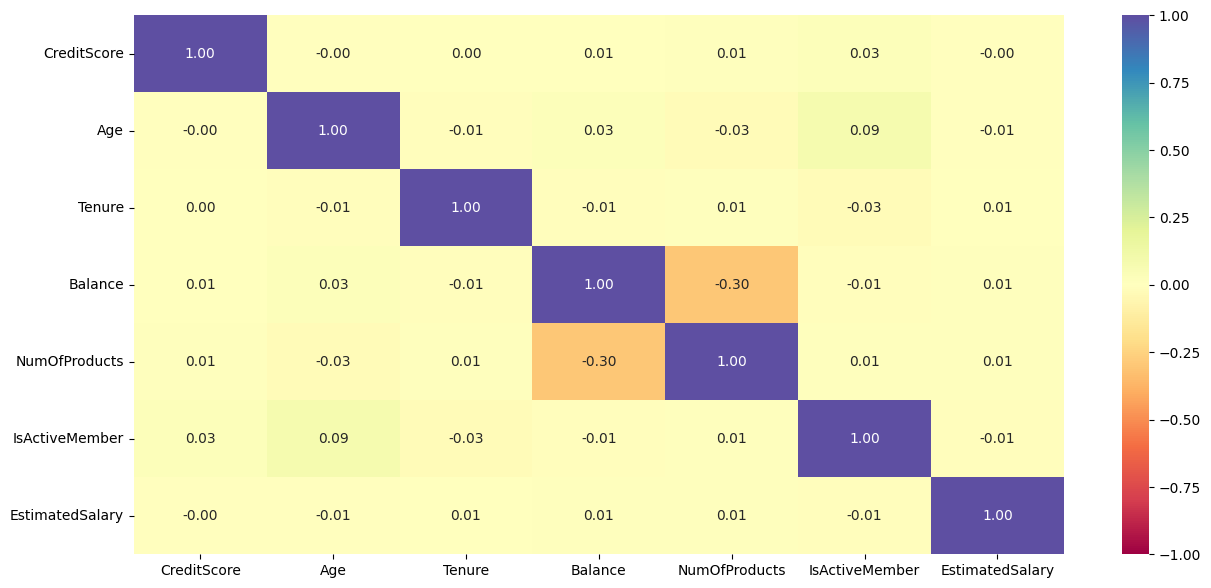

In [ ]:
plt.figure(figsize=(15, 7))
sns.heatmap(data[numeric_col].corr(), annot=True, vmin=-1, vmax=1, fmt=".2f", cmap="Spectral")
plt.show()

Exited        0     1    All
Geography                   
All        7963  2037  10000
Germany    1695   814   2509
France     4204   810   5014
Spain      2064   413   2477
------------------------------------------------------------------------------------------------------------------------


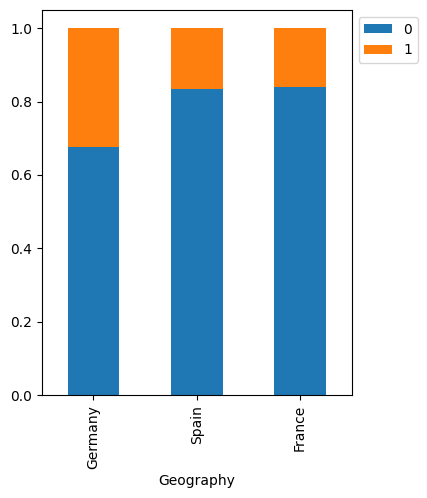

In [ ]:
stacked_barplot(data, "Geography", "Exited")

Here, we see that the decision to exit the bank has a dependency structure as a function of geography where German customers were more likely to churn relative to Spanish and French customers.

Exited     0     1    All
Gender                   
All     7963  2037  10000
Female  3404  1139   4543
Male    4559   898   5457
------------------------------------------------------------------------------------------------------------------------


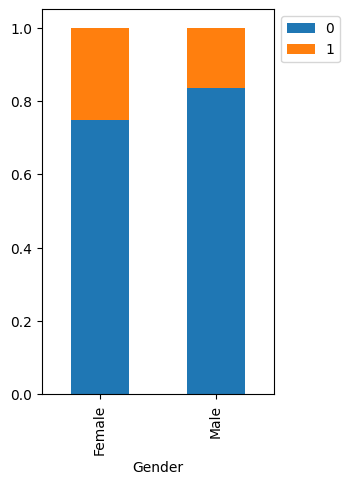

In [ ]:
stacked_barplot(data, "Gender", "Exited")

Of note, female customers were more likely to churn

Exited             0     1    All
IsActiveMember                   
All             7963  2037  10000
0               3547  1302   4849
1               4416   735   5151
------------------------------------------------------------------------------------------------------------------------


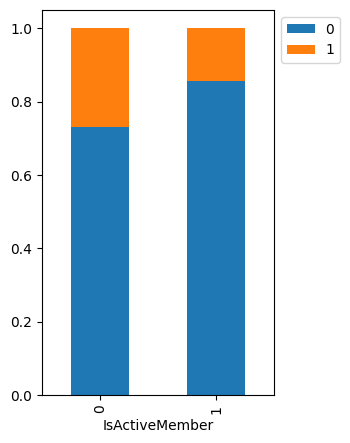

In [ ]:
stacked_barplot(data, "IsActiveMember", "Exited")

Active members were less likely to churn than non-active members.

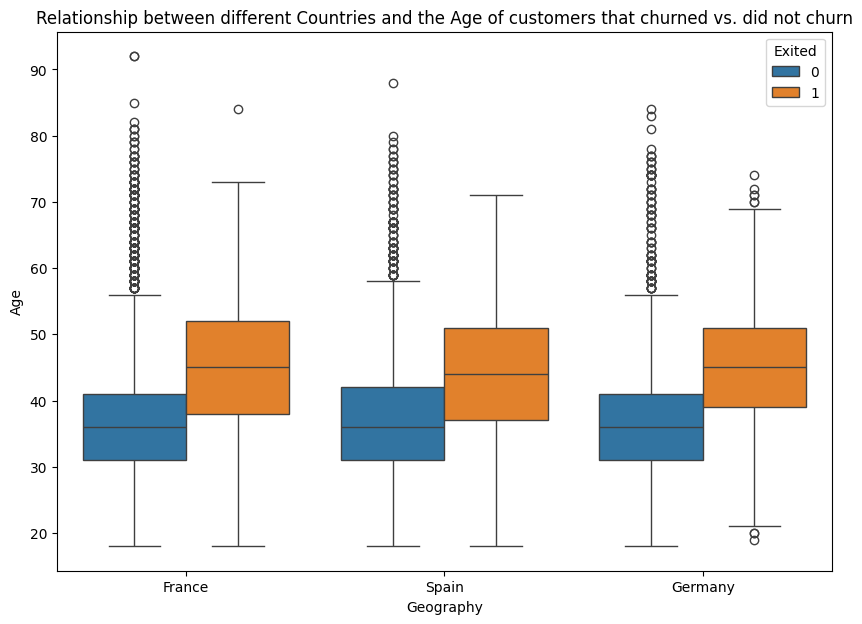

In [ ]:
plt.figure(figsize=(10,7))
sns.boxplot(data=data,
             x='Geography',
             y='Age',
             hue='Exited')
plt.title('Relationship between different Countries and the Age of customers that churned vs. did not churn')
plt.show()

As can be seen, for customers that churned in every country, those customers had higher median ages than customers that did not churn.

##Data Preprocessing

In [ ]:
#Drop Surname variable as it won't add anything of predictive value to the model
data.drop('Surname', axis = 1, inplace = True)

In [ ]:
#Drop Rownumber and Customer ID
data.drop(['RowNumber', 'CustomerId'], axis = 1, inplace = True)

###Encoding the categorical variables

In [ ]:
## Separating Independent and Dependent Columns
X = data.drop(['Exited'],axis=1)
Y = data['Exited']

In [ ]:
# Encoding the categorical variables using one-hot encoding
X = pd.get_dummies(X, columns=['Geography', 'Gender', 'HasCrCard'], drop_first=True,)

##Normalizing numeric variables

In [ ]:
#Standardizing the numerical variables to zero mean and unit variance.
transformer = StandardScaler()
X[numeric_col] = transformer.fit_transform(X[numeric_col])

###Splitting the dataset

In [ ]:
# Splitting the dataset into the Training and Test set.
X_train, X_test, y_train, y_test = train_test_split(X,Y, test_size = 0.2, random_state = 42,stratify = Y)

In [ ]:
# Splitting the Train dataset into the Training and Validation set.
X_train, X_valid, y_train, y_valid = train_test_split(X_train,y_train, test_size = 0.2, random_state = 42,stratify = y_train)

In [ ]:
#Printing the shapes.
print(X_train.shape,y_train.shape)
print(X_valid.shape,y_valid.shape)
print(X_test.shape,y_test.shape)

(6400, 11) (6400,)
(1600, 11) (1600,)
(2000, 11) (2000,)


###Utility Functions

In [ ]:
def plot(history, name):
    """
    Function to plot loss/accuracy

    history: an object which stores the metrics and losses.
    name: can be one of Loss or Accuracy
    """
    fig, ax = plt.subplots() #Creating a subplot with figure and axes.
    plt.plot(history.history[name]) #Plotting the train accuracy or train loss
    plt.plot(history.history['val_'+name]) #Plotting the validation accuracy or validation loss

    plt.title('Model ' + name.capitalize()) #Defining the title of the plot.
    plt.ylabel(name.capitalize()) #Capitalizing the first letter.
    plt.xlabel('Epoch') #Defining the label for the x-axis.
    fig.legend(['Train', 'Validation'], loc="outside right upper") #Defining the legend, loc controls the position of the legend.

In [ ]:
!pip install scikit-learn

import numpy as np
from sklearn.metrics import confusion_matrix, recall_score, precision_score, f1_score, accuracy_score, roc_auc_score

def model_performance_classification(model, predictors, target, threshold=0.5):
    """
    Function to compute different metrics to check classification model performance

    model: classifier
    predictors: independent variables
    target: dependent variable
    threshold: threshold for classifying the observation as class 1
    """

    # predicting using the independent variables
    pred_proba = model.predict(predictors)

    # if the predicted probability is greater than threshold, then give class as 1
    # otherwise give class as 0
    if pred_proba.shape[1] == 1:  # Check if only one class probability is predicted
        pred = (pred_proba > threshold).astype(int)
    else:
        pred = (pred_proba[:, 1] > threshold).astype(int)  # Use second column for binary classification

    # pred = np.round(pred_temp)

    acc = accuracy_score(target, pred)  # to compute Accuracy
    recall = recall_score(target, pred)  # to compute Recall
    precision = precision_score(target, pred)  # to compute Precision
    f1 = f1_score(target, pred)  # to compute F1-score

    # creating a dataframe of metrics
    df_perf = pd.DataFrame(
        {
            "Accuracy": acc,
            "Recall": recall,
            "Precision": precision,
            "F1": f1,
        },
        index=[0],
    )

    return df_perf

##Model Building

###Model Evaluation Criteria

**A predictive model can make wrong prediction in the following ways**


*   Predicting that a customer has churned when they did not do so.
*   Predicting that a customer has NOT churned, when in fact they have.

**Which case is more important?**

For this project, both predictions are critical as predicting that a customer has churned may cause the bank to invest resources in customer retention that weren't necessary ; resources that could've been invested in an actual customer that churned, but was predicted not to do so.

**How to reduce this loss i.e. the need to minimize False Negatives and False Positives?**

We would want our F1 score metric to me maximized rather than just maximizing Recall or Precision in this case.



###Class weights for imbalanced dataset

In [ ]:
# Calculate class weights for imbalanced dataset
cw = (y_train.shape[0]) / np.bincount(y_train)

# Create a dictionary mapping class indices to their respective class weights
cw_dict = {}
for i in range(cw.shape[0]):
    cw_dict[i] = cw[i]

cw_dict

{0: 1.2558869701726845, 1: 4.9079754601226995}

In [ ]:
# defining the batch size and # epochs upfront as we'll be using the same values for all models
epochs = 13
batch_size = 32

###Model 0

Let's start with a neural network with:
* two hidden layers with 13 and 6 neurons respectively
* ReLU activation function
* SGD as the optimizer

In [ ]:
# clears the current Keras session, resetting all layers and models previously created, freeing up memory and resources.
tf.keras.backend.clear_session()

In [ ]:
#Initializing the neural network
model = Sequential()
model.add(Dense(13,activation="relu",input_dim=X_train.shape[1]))
model.add(Dense(6,activation="relu"))
model.add(Dense(1,activation="sigmoid"))

In [ ]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense (Dense)                        │ (None, 13)                  │             156 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 6)                   │              84 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 1)                   │               7 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 247 (988.00 B)

 Trainable params: 247 (988.00 B)

 Non-trainable params: 0 (0.00 B)

In [ ]:
optimizer = tf.keras.optimizers.SGD()    # defining SGD as the optimizer to be used
model.compile(loss='binary_crossentropy', optimizer=optimizer)

In [ ]:
#Convert Pandas Series to NumPy arrays (suggested AI coding error fix)
X_train = np.array(X_train)
y_train = np.array(y_train)
X_valid = np.array(X_valid)
y_valid = np.array(y_valid)
y_train = y_train.astype('float32')
y_valid = y_valid.astype('float32')
X_train = X_train.astype('float32')
X_valid = X_valid.astype('float32')

In [ ]:
import time
start = time.time()
history = model.fit(X_train, y_train, validation_data=(X_valid,y_valid) , batch_size=batch_size, epochs=epochs, class_weight=cw_dict)
end=time.time()

Epoch 1/13
200/200 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 1.3402 - val_loss: 0.6321
Epoch 2/13
200/200 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 1.1921 - val_loss: 0.5978
Epoch 3/13
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 1.1099 - val_loss: 0.5780
Epoch 4/13
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 1.1586 - val_loss: 0.5449
Epoch 5/13
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 1.1048 - val_loss: 0.5468
Epoch 6/13
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 1.0528 - val_loss: 0.5413
Epoch 7/13
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 1.0416 - val_loss: 0.5141
Epoch 8/13
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 1.0232 - val_loss: 0.5561
Epoch 9/13
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.9994 - val_loss: 0.4867
Epoch 10/13
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.9727 - val_loss: 0.5128
Epoch 11/13
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.9827 - val_loss: 0.4858
Epoch 12/13
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step

In [ ]:
print("Time taken in seconds ",end-start)

Time taken in seconds  18.167354822158813


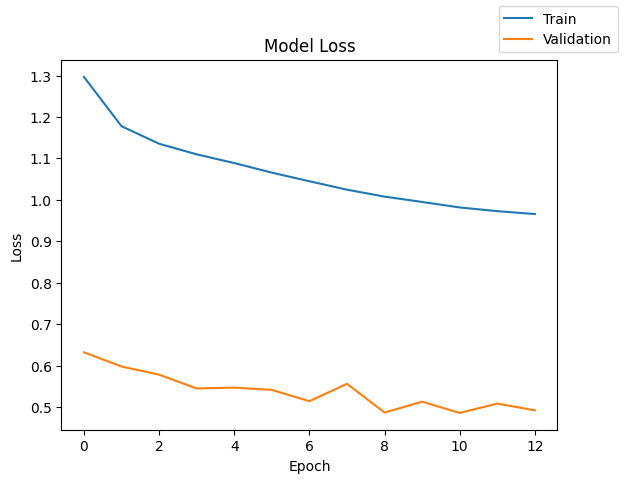

In [ ]:
plot(history,'loss')

In [ ]:
model_0_train_perf = model_performance_classification(model, X_train, y_train)
model_0_train_perf

200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


,Accuracy,Recall,Precision,F1
0,0.772344,0.769939,0.4646,0.579509


In [ ]:
model_0_valid_perf = model_performance_classification(model, X_valid, y_valid)
model_0_valid_perf

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


,Accuracy,Recall,Precision,F1
0,0.753125,0.733129,0.436929,0.547537


##Model 1

In [ ]:
# clears the current Keras session, resetting all layers and models previously created, freeing up memory and resources.
tf.keras.backend.clear_session()

In [ ]:
#Initializing the neural network
model = Sequential()
model.add(Dense(13,activation="relu",input_dim=X_train.shape[1]))
model.add(Dense(6,activation="relu"))
model.add(Dense(1,activation="sigmoid"))

In [ ]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense (Dense)                        │ (None, 13)                  │             156 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 6)                   │              84 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 1)                   │               7 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 247 (988.00 B)

 Trainable params: 247 (988.00 B)

 Non-trainable params: 0 (0.00 B)

In [ ]:
optimizer = tf.keras.optimizers.SGD(momentum=0.9)    # defining SGD as the optimizer to be used
model.compile(loss='binary_crossentropy', optimizer=optimizer)

In [ ]:
start = time.time()
history = model.fit(X_train, y_train, validation_data=(X_valid,y_valid) , batch_size=batch_size, epochs=epochs,class_weight = cw_dict)
end=time.time()

Epoch 1/13
200/200 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 1.3268 - val_loss: 0.5813
Epoch 2/13
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 1.1812 - val_loss: 0.5734
Epoch 3/13
200/200 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 1.1093 - val_loss: 0.5266
Epoch 4/13
200/200 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - loss: 0.9900 - val_loss: 0.5342
Epoch 5/13
200/200 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.9780 - val_loss: 0.4501
Epoch 6/13
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.9407 - val_loss: 0.5161
Epoch 7/13
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.9332 - val_loss: 0.4220
Epoch 8/13
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.9596 - val_loss: 0.4430
Epoch 9/13
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.9124 - val_loss: 0.4227
Epoch 10/13
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.9046 - val_loss: 0.4944
Epoch 11/13
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.9041 - val_loss: 0.3959
Epoch 12/13
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step

In [ ]:
print("Time taken in seconds ",end-start)

Time taken in seconds  15.05896544456482


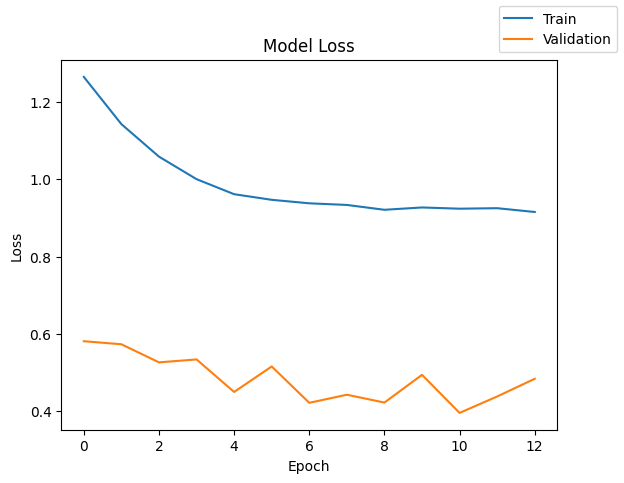

In [ ]:
plot(history,'loss')

In [ ]:
model_1_train_perf = model_performance_classification(model, X_train, y_train)
model_1_train_perf

200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


,Accuracy,Recall,Precision,F1
0,0.790469,0.78911,0.491169,0.605472


In [ ]:
model_1_valid_perf = model_performance_classification(model, X_valid, y_valid)
model_1_valid_perf

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


,Accuracy,Recall,Precision,F1
0,0.771875,0.769939,0.463956,0.579008


##Model 2

ADAM optimizer

In [ ]:
# clears the current Keras session, resetting all layers and models previously created, freeing up memory and resources.
tf.keras.backend.clear_session()

In [ ]:
#Initializing the neural network
model = Sequential()
model.add(Dense(13,activation="relu",input_dim=X_train.shape[1]))
model.add(Dense(6,activation="relu"))
model.add(Dense(1,activation="sigmoid"))

In [ ]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense (Dense)                        │ (None, 13)                  │             156 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 6)                   │              84 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 1)                   │               7 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 247 (988.00 B)

 Trainable params: 247 (988.00 B)

 Non-trainable params: 0 (0.00 B)

In [ ]:
optimizer = tf.keras.optimizers.Adam()    # defining Adam as the optimizer to be used
model.compile(loss='binary_crossentropy', optimizer=optimizer)

In [ ]:
start = time.time()
history = model.fit(X_train, y_train, validation_data=(X_valid,y_valid) , batch_size=batch_size, epochs=epochs,class_weight=cw_dict)
end=time.time()

Epoch 1/13
200/200 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 1.3593 - val_loss: 0.6777
Epoch 2/13
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 1.2166 - val_loss: 0.5993
Epoch 3/13
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 1.1094 - val_loss: 0.5718
Epoch 4/13
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 1.0623 - val_loss: 0.5289
Epoch 5/13
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 1.0310 - val_loss: 0.5075
Epoch 6/13
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.9780 - val_loss: 0.4760
Epoch 7/13
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.9836 - val_loss: 0.5079
Epoch 8/13
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.9616 - val_loss: 0.4868
Epoch 9/13
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.9698 - val_loss: 0.4664
Epoch 10/13
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.9778 - val_loss: 0.4624
Epoch 11/13
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.9493 - val_loss: 0.5057
Epoch 12/13
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step

In [ ]:
print("Time taken in seconds ",end-start)

Time taken in seconds  10.007898807525635


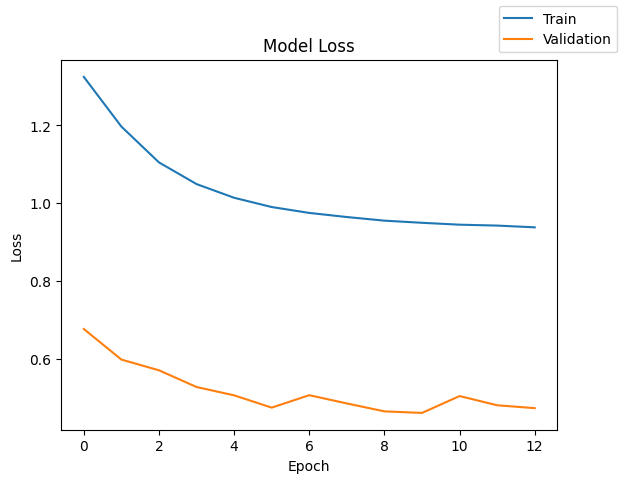

In [ ]:
plot(history,'loss')

In [ ]:
model_2_train_perf = model_performance_classification(model, X_train, y_train)
model_2_train_perf

200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


,Accuracy,Recall,Precision,F1
0,0.787969,0.755368,0.486901,0.592125


In [ ]:
model_2_valid_perf = model_performance_classification(model, X_valid, y_valid)
model_2_valid_perf

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


,Accuracy,Recall,Precision,F1
0,0.77625,0.736196,0.46875,0.572792


##Model 3

In [ ]:
# clears the current Keras session, resetting all layers and models previously created, freeing up memory and resources.
tf.keras.backend.clear_session()

In [ ]:
#Initializing the neural network
model = Sequential()
model.add(Dense(13,activation="relu",input_dim=X_train.shape[1]))
model.add(Dropout(0.4))
model.add(Dense(6,activation="relu"))
model.add(Dropout(0.2))
model.add(Dense(1,activation="sigmoid"))

In [ ]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense (Dense)                        │ (None, 13)                  │             156 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 13)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 6)                   │              84 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 6)                   │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 1)                   │               7 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 247 (988.00 B)

 Trainable params: 247 (988.00 B)

 Non-trainable params: 0 (0.00 B)

In [ ]:
optimizer = tf.keras.optimizers.Adam()    # defining Adam as the optimizer to be used
model.compile(loss='binary_crossentropy', optimizer=optimizer)

In [ ]:
start = time.time()
history = model.fit(X_train, y_train, validation_data=(X_valid,y_valid) , batch_size=batch_size, epochs=epochs,class_weight=cw_dict)
end=time.time()

Epoch 1/13
200/200 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 1.4086 - val_loss: 0.6720
Epoch 2/13
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.3393 - val_loss: 0.6324
Epoch 3/13
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 1.2626 - val_loss: 0.6071
Epoch 4/13
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 1.2323 - val_loss: 0.5784
Epoch 5/13
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 1.2151 - val_loss: 0.5693
Epoch 6/13
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 1.1944 - val_loss: 0.5491
Epoch 7/13
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.1909 - val_loss: 0.5456
Epoch 8/13
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.1912 - val_loss: 0.5329
Epoch 9/13
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 1.1357 - val_loss: 0.5369
Epoch 10/13
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 1.1286 - val_loss: 0.5277
Epoch 11/13
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 1.1278 - val_loss: 0.5381
Epoch 12/13
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step

In [ ]:
print("Time taken in seconds ",end-start)

Time taken in seconds  10.26312780380249


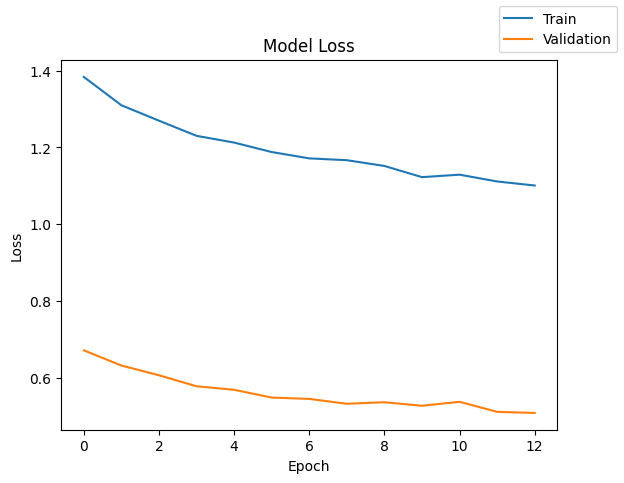

In [ ]:
plot(history,'loss')

In [ ]:
model_3_train_perf = model_performance_classification(model, X_train, y_train)
model_3_train_perf

200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


,Accuracy,Recall,Precision,F1
0,0.786875,0.735429,0.484833,0.5844


In [ ]:
model_3_valid_perf = model_performance_classification(model, X_valid, y_valid)
model_3_valid_perf

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


,Accuracy,Recall,Precision,F1
0,0.775625,0.711656,0.466801,0.563791


##Model 4
Batch Normalization as scores are still unsatisfactory

In [ ]:
# clears the current Keras session, resetting all layers and models previously created, freeing up memory and resources.
tf.keras.backend.clear_session()

In [ ]:
#Initializing the neural network
model = Sequential()
model.add(Dense(13,activation="relu",input_dim=X_train.shape[1]))
model.add(BatchNormalization())
model.add(Dense(6,activation="relu"))
model.add(BatchNormalization())
model.add(Dense(1,activation="sigmoid"))

In [ ]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense (Dense)                        │ (None, 13)                  │             156 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 13)                  │              52 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 6)                   │              84 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 6)                   │              24 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 1)                   │               7 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 323 (1.26 KB)

 Trainable params: 285 (1.11 KB)

 Non-trainable params: 38 (152.00 B)

In [ ]:
optimizer = tf.keras.optimizers.Adam()    # defining Adam as the optimizer to be used
model.compile(loss='binary_crossentropy', optimizer=optimizer)

In [ ]:
start = time.time()
history = model.fit(X_train, y_train, validation_data=(X_valid,y_valid) , batch_size=batch_size, epochs=epochs,class_weight=cw_dict)
end=time.time()

Epoch 1/13
200/200 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 1.5081 - val_loss: 0.6500
Epoch 2/13
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.2415 - val_loss: 0.5964
Epoch 3/13
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.1292 - val_loss: 0.5703
Epoch 4/13
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 1.1399 - val_loss: 0.5539
Epoch 5/13
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 1.0777 - val_loss: 0.5429
Epoch 6/13
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 1.0813 - val_loss: 0.5285
Epoch 7/13
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 1.0572 - val_loss: 0.5167
Epoch 8/13
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 1.0465 - val_loss: 0.4899
Epoch 9/13
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.9959 - val_loss: 0.4896
Epoch 10/13
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.9990 - val_loss: 0.4823
Epoch 11/13
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 1.0095 - val_loss: 0.4815
Epoch 12/13
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step

In [ ]:
print("Time taken in seconds ",end-start)

Time taken in seconds  11.106757640838623


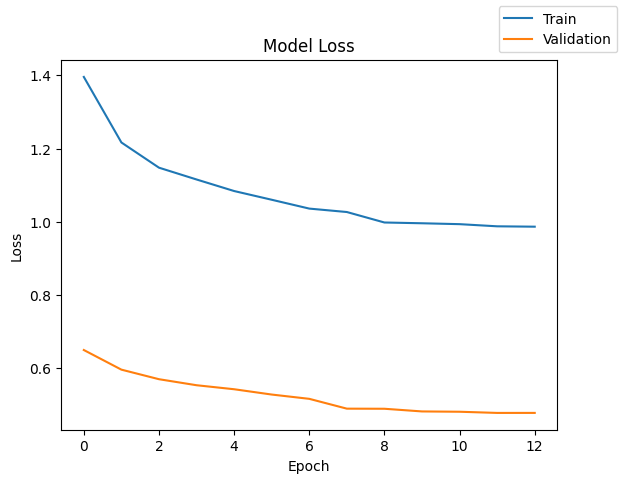

In [ ]:
plot(history,'loss')

In [ ]:
model_4_train_perf = model_performance_classification(model, X_train, y_train)
model_4_train_perf

200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


,Accuracy,Recall,Precision,F1
0,0.775937,0.782209,0.470046,0.587219


In [ ]:
model_4_valid_perf = model_performance_classification(model, X_valid, y_valid)
model_4_valid_perf

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


,Accuracy,Recall,Precision,F1
0,0.76375,0.751534,0.45203,0.564516


Slight improvement seen

##Model 5
Batch normalization and dropout

In [ ]:
# clears the current Keras session, resetting all layers and models previously created, freeing up memory and resources.
tf.keras.backend.clear_session()

In [ ]:
#Initializing the neural network
model = Sequential()
model.add(Dense(14,activation="relu",input_dim=X_train.shape[1]))
model.add(BatchNormalization())
model.add(Dropout(0.4))
model.add(Dense(7,activation="relu"))
model.add(BatchNormalization())
model.add(Dropout(0.2))
model.add(Dense(1,activation="sigmoid"))

In [ ]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense (Dense)                        │ (None, 14)                  │             168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 14)                  │              56 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 14)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 7)                   │             105 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 7)                   │              28 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 7)                   │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 1)                   │               8 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 365 (1.43 KB)

 Trainable params: 323 (1.26 KB)

 Non-trainable params: 42 (168.00 B)

In [ ]:
optimizer = tf.keras.optimizers.Adam()    # defining Adam as the optimizer to be used
model.compile(loss='binary_crossentropy', optimizer=optimizer)

In [ ]:
start = time.time()
history = model.fit(X_train, y_train, validation_data=(X_valid,y_valid) , batch_size=batch_size, epochs=epochs,class_weight=cw_dict)
end=time.time()

Epoch 1/13
200/200 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 1.4313 - val_loss: 0.6714
Epoch 2/13
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.2764 - val_loss: 0.6340
Epoch 3/13
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 1.2354 - val_loss: 0.6148
Epoch 4/13
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 1.2205 - val_loss: 0.6008
Epoch 5/13
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 1.1948 - val_loss: 0.5839
Epoch 6/13
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 1.2023 - val_loss: 0.5726
Epoch 7/13
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 1.1700 - val_loss: 0.5554
Epoch 8/13
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 1.1541 - val_loss: 0.5493
Epoch 9/13
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 1.1402 - val_loss: 0.5487
Epoch 10/13
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 1.1576 - val_loss: 0.5474
Epoch 11/13
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.1294 - val_loss: 0.5349
Epoch 12/13
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step

In [ ]:
print("Time taken in seconds ",end-start)

Time taken in seconds  10.748682737350464


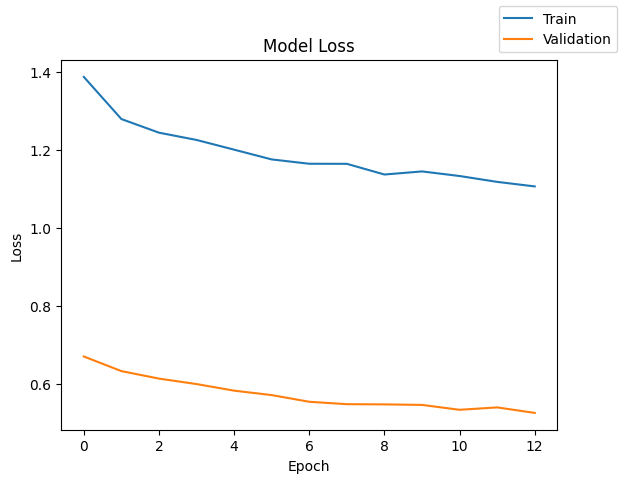

In [ ]:
plot(history,'loss')

In [ ]:
model_5_train_perf = model_performance_classification(model, X_train, y_train)
model_5_train_perf

200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


,Accuracy,Recall,Precision,F1
0,0.737812,0.79908,0.423922,0.553961


In [ ]:
model_5_valid_perf = model_performance_classification(model, X_valid, y_valid)
model_5_valid_perf

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


,Accuracy,Recall,Precision,F1
0,0.723125,0.788344,0.40729,0.537095


F1 scores decreasing relative to earlier models

##Model 6
Initialize weights using He Normal.
Attempt dropout for regularzation.

In [ ]:
# clears the current Keras session, resetting all layers and models previously created, freeing up memory and resources.
tf.keras.backend.clear_session()

In [ ]:
#Initializing the neural network
model = Sequential()
model.add(Dense(13,activation="relu",kernel_initializer="he_normal",input_dim=X_train.shape[1]))
model.add(Dropout(0.4))
model.add(Dense(6,activation="relu",kernel_initializer="he_normal"))
model.add(Dropout(0.2))
model.add(Dense(1,activation="sigmoid",kernel_initializer="he_normal"))

In [ ]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense (Dense)                        │ (None, 13)                  │             156 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 13)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 6)                   │              84 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 6)                   │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 1)                   │               7 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 247 (988.00 B)

 Trainable params: 247 (988.00 B)

 Non-trainable params: 0 (0.00 B)

In [ ]:
optimizer = tf.keras.optimizers.Adam()    # defining Adam as the optimizer to be used
model.compile(loss='binary_crossentropy', optimizer=optimizer)

In [ ]:
start = time.time()
history = model.fit(X_train, y_train, validation_data=(X_valid,y_valid) , batch_size=batch_size, epochs=epochs,class_weight=cw_dict)
end=time.time()

Epoch 1/13
200/200 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 1.5440 - val_loss: 0.6476
Epoch 2/13
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 1.3861 - val_loss: 0.6452
Epoch 3/13
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.3444 - val_loss: 0.6425
Epoch 4/13
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 1.3109 - val_loss: 0.6279
Epoch 5/13
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.2699 - val_loss: 0.6047
Epoch 6/13
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 1.2730 - val_loss: 0.5957
Epoch 7/13
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 1.2403 - val_loss: 0.5839
Epoch 8/13
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 1.2487 - val_loss: 0.5793
Epoch 9/13
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 1.2340 - val_loss: 0.5753
Epoch 10/13
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 1.1941 - val_loss: 0.5617
Epoch 11/13
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 1.2264 - val_loss: 0.5558
Epoch 12/13
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step

In [ ]:
print("Time taken in seconds ",end-start)

Time taken in seconds  9.567255735397339


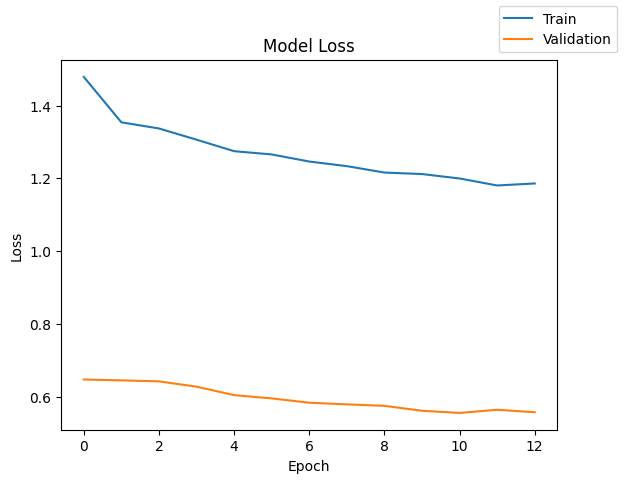

In [ ]:
plot(history,'loss')

In [ ]:
model_6_train_perf = model_performance_classification(model, X_train, y_train)
model_6_train_perf

200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


,Accuracy,Recall,Precision,F1
0,0.742812,0.740798,0.424802,0.539966


In [ ]:
model_6_valid_perf = model_performance_classification(model, X_valid, y_valid)
model_6_valid_perf

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


,Accuracy,Recall,Precision,F1
0,0.729375,0.730061,0.408233,0.523652


F1 score unacceptable

## Model Performance Comparison and Final Model Selection

In [ ]:
# training performance comparison

models_train_comp_df = pd.concat(
    [
        model_0_train_perf.T,
        model_1_train_perf.T,
        model_2_train_perf.T,
        model_3_train_perf.T,
        model_4_train_perf.T,
        model_5_train_perf.T,
        model_6_train_perf.T
    ],
    axis=1,
)
models_train_comp_df.columns = [
    "Neural Network (SGD, No Regularization)",
    "Neural Network (SGD with Momentum, No Regularization)",
    "Neural Network (Adam , No Regularization)",
    "Neural Network (Adam, dropout [0.4,0.2])",
    "Neural Network (Adam, Batch Normalization)",
    "Neural Network (dropout [0.4,0.2], Batch Normalization)",
    "Neural Network (Adam,dropout [0.4,0.2] ,He initialization)"
]

In [ ]:
#Validation performance comparison

models_valid_comp_df = pd.concat(
    [
        model_0_valid_perf.T,
        model_1_valid_perf.T,
        model_2_valid_perf.T,
        model_3_valid_perf.T,
        model_4_valid_perf.T,
        model_5_valid_perf.T,
        model_6_valid_perf.T
    ],
    axis=1,
)
models_valid_comp_df.columns = [
    "Neural Network (SGD, No Regularization)",
    "Neural Network (SGD with Momentum, No Regularization)",
    "Neural Network (Adam , No Regularization)",
    "Neural Network (Adam, dropout [0.4,0.2])",
    "Neural Network (Adam, Batch Normalization)",
    "Neural Network (dropout [0.4,0.2], Batch Normalization)",
    "Neural Network (Adam,dropout [0.4,0.2] ,He initialization)"
]

In [ ]:
models_train_comp_df

,"Neural Network (SGD, No Regularization)","Neural Network (SGD with Momentum, No Regularization)","Neural Network (Adam , No Regularization)","Neural Network (Adam, dropout [0.4,0.2])","Neural Network (Adam, Batch Normalization)","Neural Network (dropout [0.4,0.2], Batch Normalization)","Neural Network (Adam,dropout [0.4,0.2] ,He initialization)"
Accuracy,0.772344,0.790469,0.787969,0.786875,0.775937,0.737812,0.742812
Recall,0.769939,0.789110,0.755368,0.735429,0.782209,0.799080,0.740798
Precision,0.464600,0.491169,0.486901,0.484833,0.470046,0.423922,0.424802
F1,0.579509,0.605472,0.592125,0.584400,0.587219,0.553961,0.539966


In [ ]:
models_valid_comp_df

,"Neural Network (SGD, No Regularization)","Neural Network (SGD with Momentum, No Regularization)","Neural Network (Adam , No Regularization)","Neural Network (Adam, dropout [0.4,0.2])","Neural Network (Adam, Batch Normalization)","Neural Network (dropout [0.4,0.2], Batch Normalization)","Neural Network (Adam,dropout [0.4,0.2] ,He initialization)"
Accuracy,0.753125,0.771875,0.776250,0.775625,0.763750,0.723125,0.729375
Recall,0.733129,0.769939,0.736196,0.711656,0.751534,0.788344,0.730061
Precision,0.436929,0.463956,0.468750,0.466801,0.452030,0.407290,0.408233
F1,0.547537,0.579008,0.572792,0.563791,0.564516,0.537095,0.523652


In [ ]:
# Calculate the difference in 'F1 Score' if it exists in the index
if 'F1 Score' in models_train_comp_df.index and 'F1 Score' in models_valid_comp_df.index:
    difference = models_train_comp_df.loc["F1 Score"] - models_valid_comp_df.loc["F1 Score"]
    print(difference)
else:
    print("'F1 Score' not found in the index of one or both DataFrames.")
    print("Available indices in models_train_comp_df:", models_train_comp_df.index.tolist())
    print("Available indices in models_valid_comp_df:", models_valid_comp_df.index.tolist())

'F1 Score' not found in the index of one or both DataFrames.
Available indices in models_train_comp_df: ['Accuracy', 'Recall', 'Precision', 'F1']
Available indices in models_valid_comp_df: ['Accuracy', 'Recall', 'Precision', 'F1']


In [ ]:
models_train_comp_df.loc["F1"] - models_valid_comp_df.loc["F1"]

,F1
"Neural Network (SGD, No Regularization)",0.031972
"Neural Network (SGD with Momentum, No Regularization)",0.026464
"Neural Network (Adam , No Regularization)",0.019333
"Neural Network (Adam, dropout [0.4,0.2])",0.020609
"Neural Network (Adam, Batch Normalization)",0.022703
"Neural Network (dropout [0.4,0.2], Batch Normalization)",0.016866
"Neural Network (Adam,dropout [0.4,0.2] ,He initialization)",0.016314


* Final Model: SGD with momentum, no regularization
* Training F1 score: ~.61 ; Validation F1 score: .58
*These metrics indicate relatively decent performance in generalization.

##Final Model

In [ ]:
# clears the current Keras session, resetting all layers and models previously created, freeing up memory and resources.
tf.keras.backend.clear_session()

In [ ]:
#Initializing the neural network
model = Sequential()
model.add(Dense(13,activation="relu",input_dim=X_train.shape[1]))
model.add(Dense(6,activation="relu"))
model.add(Dense(1,activation="sigmoid"))

In [ ]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense (Dense)                        │ (None, 13)                  │             156 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 13)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 6)                   │              84 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 6)                   │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 1)                   │               7 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 743 (2.91 KB)

 Trainable params: 247 (988.00 B)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 496 (1.94 KB)

In [ ]:
optimizer = tf.keras.optimizers.Adam()    # defining Adam as the optimizer to be used
model.compile(loss='binary_crossentropy', optimizer=optimizer)

In [ ]:
start = time.time()
history = model.fit(X_train, y_train, validation_data=(X_valid,y_valid) , batch_size=batch_size, epochs=epochs,class_weight=cw_dict)
end=time.time()

Epoch 1/13
200/200 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - loss: 1.1597 - val_loss: 0.5474
Epoch 2/13
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 1.1429 - val_loss: 0.5443
Epoch 3/13
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.1767 - val_loss: 0.5469
Epoch 4/13
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 1.1334 - val_loss: 0.5469
Epoch 5/13
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 1.1459 - val_loss: 0.5448
Epoch 6/13
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 1.1575 - val_loss: 0.5279
Epoch 7/13
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 1.1304 - val_loss: 0.5259
Epoch 8/13
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 1.1242 - val_loss: 0.5229
Epoch 9/13
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 1.0902 - val_loss: 0.5251
Epoch 10/13
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 1.1710 - val_loss: 0.5196
Epoch 11/13
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 1.0852 - val_loss: 0.5232
Epoch 12/13
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step

In [ ]:
y_train_pred = model.predict(X_train)
y_valid_pred = model.predict(X_valid)
y_test_pred = model.predict(X_test)

200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


In [ ]:
!pip install scikit-learn
from sklearn.metrics import classification_report


In [ ]:
print("Classification Report - Train data",end="\n\n")
cr = classification_report(y_train,y_train_pred>0.5)
print(cr)

Classification Report - Train data

              precision    recall  f1-score   support

         0.0       0.93      0.75      0.83      5096
         1.0       0.44      0.78      0.56      1304

    accuracy                           0.76      6400
   macro avg       0.69      0.76      0.70      6400
weighted avg       0.83      0.76      0.78      6400



In [ ]:
print("Classification Report - Validation data",end="\n\n")
cr = classification_report(y_valid,y_valid_pred>0.5)
print(cr)

Classification Report - Validation data

              precision    recall  f1-score   support

         0.0       0.93      0.73      0.82      1274
         1.0       0.43      0.78      0.55       326

    accuracy                           0.74      1600
   macro avg       0.68      0.76      0.69      1600
weighted avg       0.83      0.74      0.77      1600



In [ ]:
print("Classification Report - Test data",end="\n\n")
cr = classification_report(y_test,y_test_pred>0.5)
print(cr)

Classification Report - Test data

              precision    recall  f1-score   support

           0       0.93      0.74      0.82      1593
           1       0.43      0.77      0.55       407

    accuracy                           0.75      2000
   macro avg       0.68      0.76      0.69      2000
weighted avg       0.83      0.75      0.77      2000



* The weighted F1 score on the test data is .77
* The F1 score of .77 is good balance between precision and recall suggesting a fair minimization of false positives and false negatives.
* The model can be upgraded going forward.

#Business Insights and Recommendations

* This model can be used with good confidence in identifying likely customers to churn. F1 scores > 0.7 are generally considered to be good in the ML community.

* The Bank would do well to focus its resources on acquiring customers that statistically don't churn in lieu of attempting to retain customers that don't fit its customer loyalty profile demographic. That strategy may ultimately grow its bottom line as the population of non-churn customers may be unaware of the bank and its services.